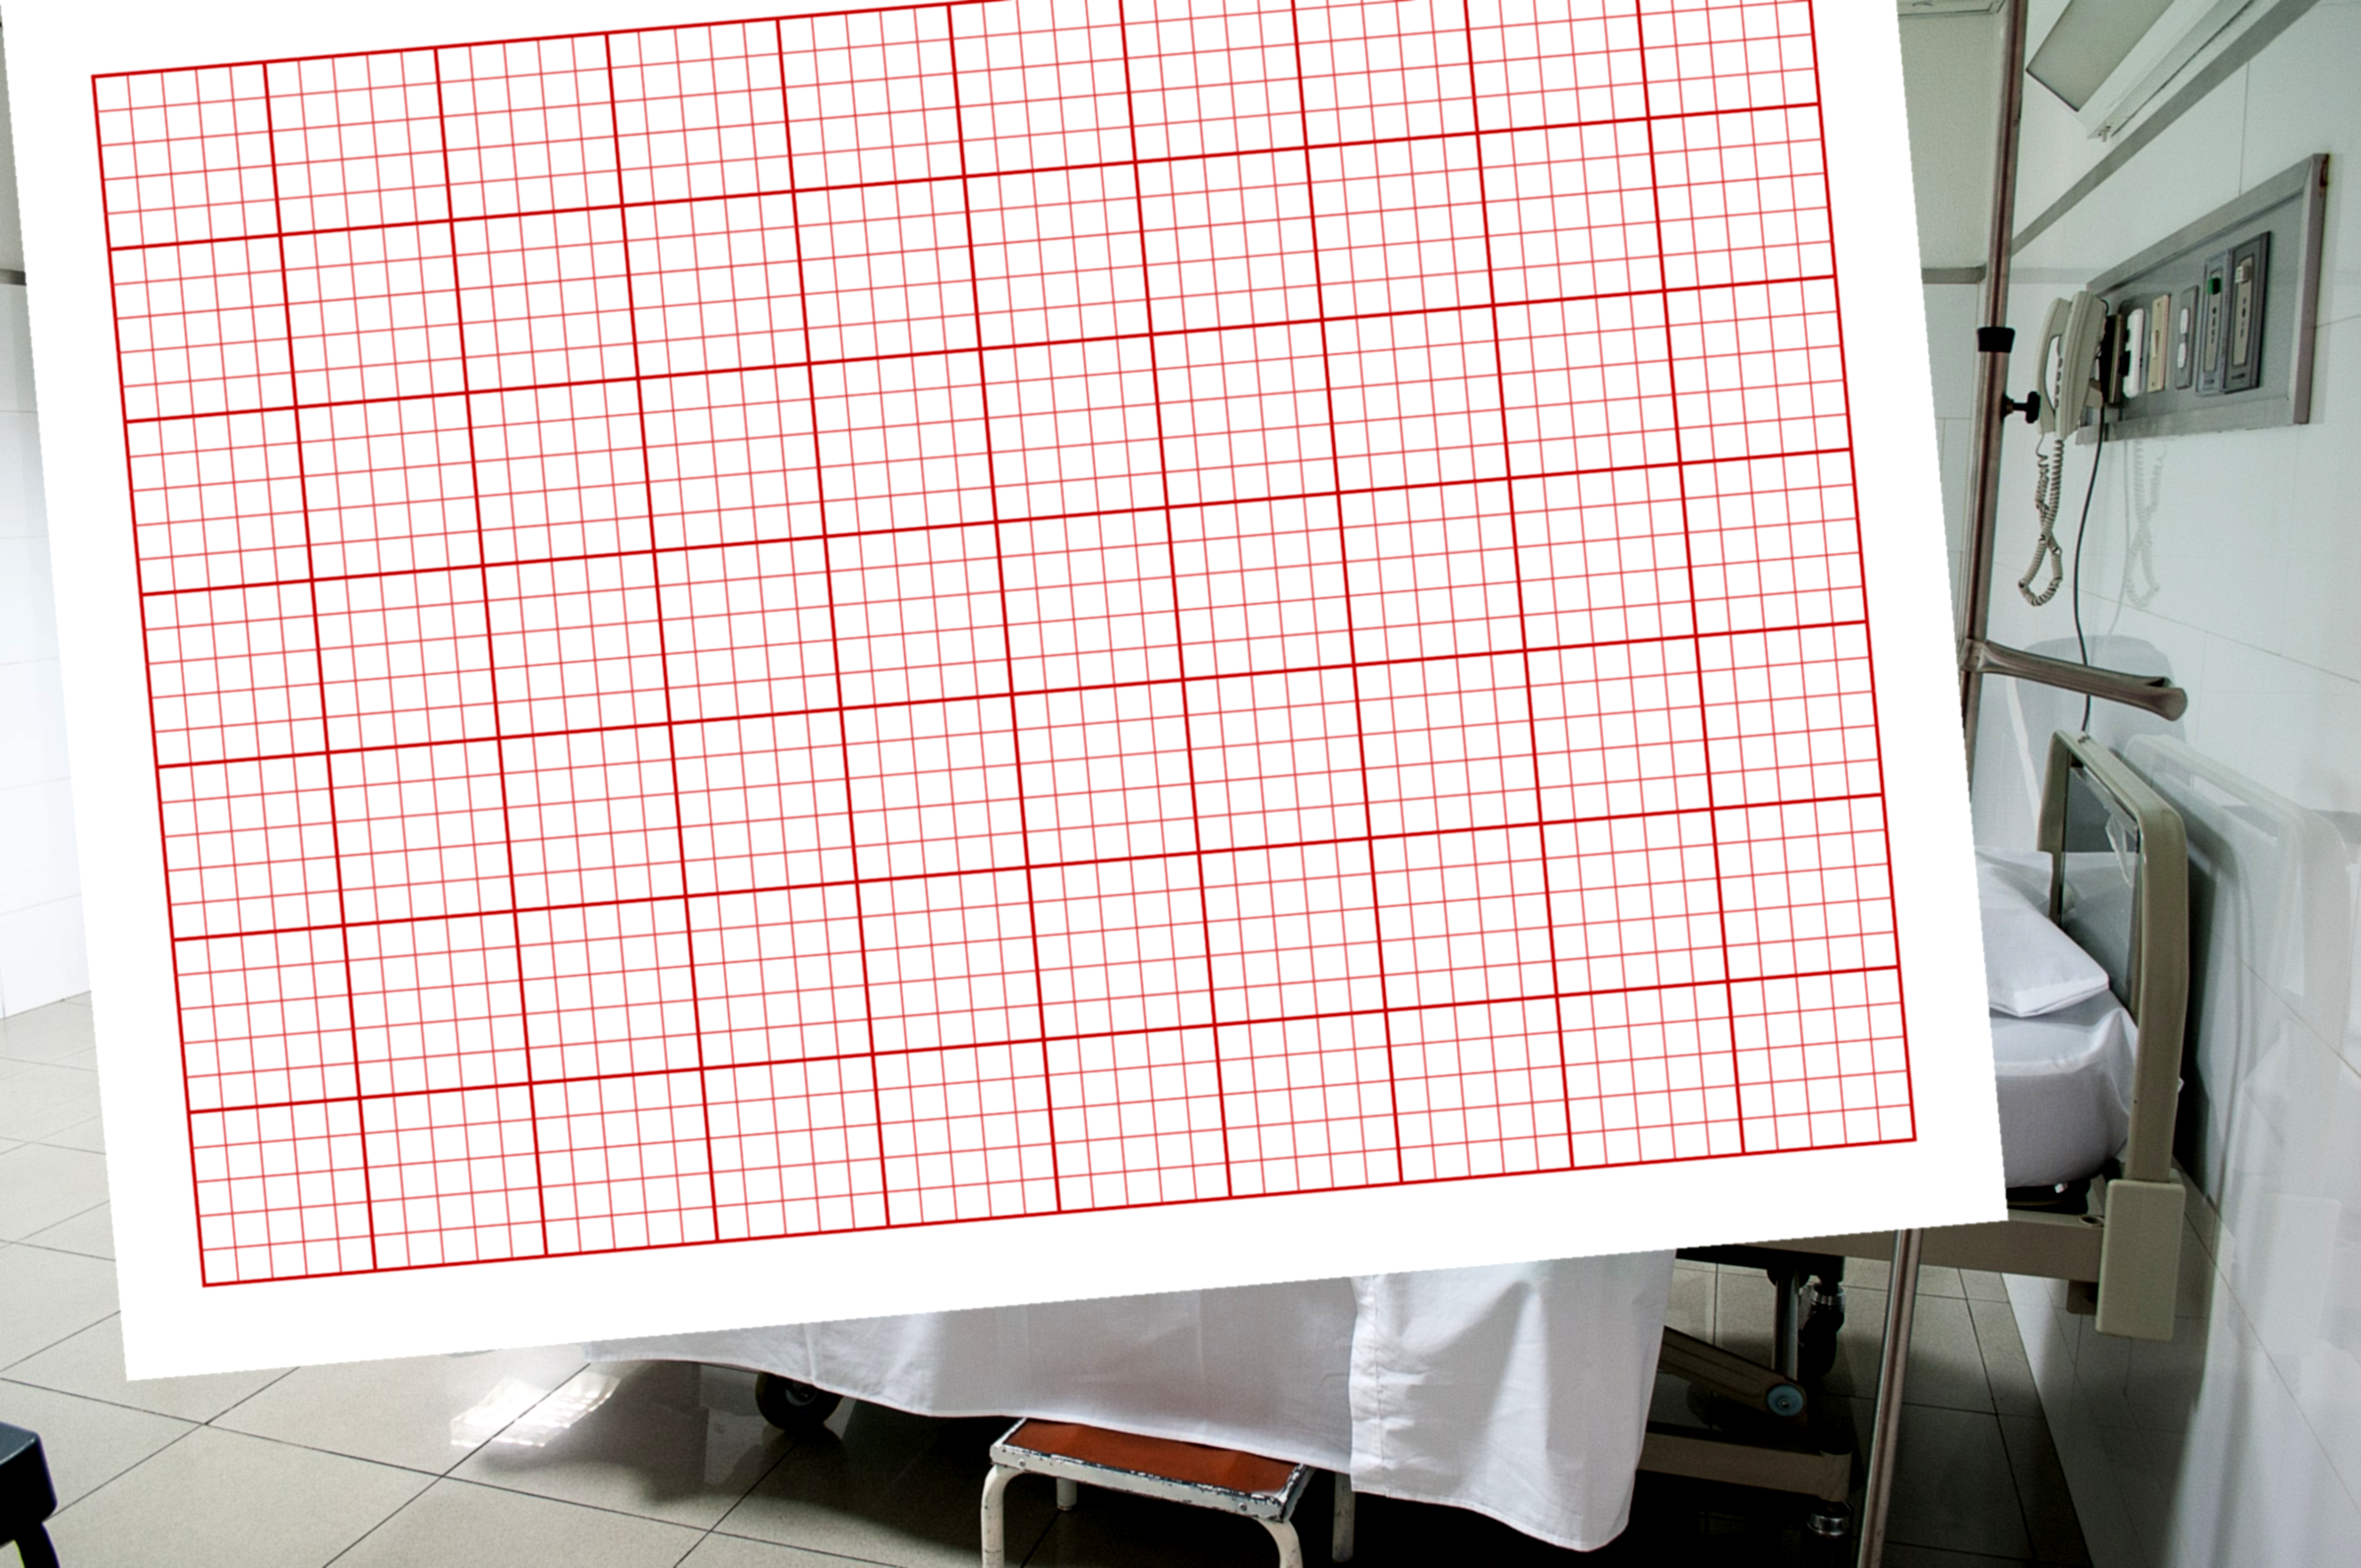

In [6]:
import random
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
import numpy as np

# shearing func: https://stackoverflow.com/a/68345146
def scale_rotate_translate(image, angle, sr_center=None, displacment=None, scale=None):
    if sr_center is None:
        sr_center = 0, 0
    if displacment is None:
        displacment = 0, 0
    if scale is None:
        scale = 1, 1

    angle = -angle / 180.0 * np.pi

    C = np.array([[1, 0, -sr_center[0]],
                  [0, 1, -sr_center[1]],
                  [0, 0, 1]])

    C_1 = np.linalg.inv(C)

    S = np.array([[scale[0], 0, 0],
                  [0, scale[1], 0],
                  [0,        0, 1]])

    R = np.array([[np.cos(angle), np.sin(angle), 0],
                  [-np.sin(angle), np.cos(angle), 0],
                  [0,                         0, 1]])

    D = np.array([[1, 0, displacment[0]],
                  [0, 1, displacment[1]],
                  [0, 0,            1]])

    Mt = np.dot(D, np.dot(C_1, np.dot(R, np.dot(S, C))))

    a, b, c = Mt[0]
    d, e, f = Mt[1]

    return image.transform((10000,10000), Image.AFFINE, (a, b, c, d, e, f), resample=Image.BICUBIC)

# Add random background images
with Image.open('images/backgrounds/bg_%.2i'% random.randint(0,15) +'.jpg').convert('RGBA') as bg:
    with Image.open('images/ecg-paper/ecg-paper-01.png').convert('RGBA') as fg:
        for i in range(1):
            #  Gaussian R.V
            mu_1, sigma_1 = 0.8, 0.1
            x_1 = np.random.normal(mu_1, sigma_1)
            mu_2, sigma_2 = 1, 0.1
            x_2 = np.random.normal(mu_2, sigma_2)
            mu_3, sigma_3 = 0, 0.1
            x_3 = np.random.normal(mu_3, sigma_3)
            mu_4, sigma_4 = 1, 0.1
            x_4 = np.random.normal(mu_4, sigma_4)
            mu_5, sigma_5 = 50, 0.1
            x_5 = np.random.normal(mu_5, sigma_5)
            mu_6, sigma_6 = 1, 0.1
            x_6 = np.random.normal(mu_6, sigma_6)
            mu_7, sigma_7 = 1, 0.1
            x_7 = np.random.normal(mu_7, sigma_7)

            # Resize the bg, fg images
            width_bg, height_bg = bg.size
            width_fg, height_fg = fg.size

            size = x_1*width_bg, x_1*height_bg
            fg.thumbnail(size, Image.ANTIALIAS)
            width_fg, height_fg = fg.size

            limit_size = 1.5*width_fg, 1.5*height_fg
            bg.thumbnail(limit_size, Image.ANTIALIAS)

            # Shadow on the fg
            if np.random.uniform() < 0.5:
                transp = Image.new('RGBA', fg.size, (0,0,0,0))
                draw = ImageDraw.Draw(transp, "RGBA")
                draw.ellipse((x_3*width_fg,x_3*height_fg, x_4*width_fg, x_4*height_fg), fill = (10, 10, 10, 100))
                transp = transp.filter(ImageFilter.GaussianBlur(x_5))
                fg.paste(Image.alpha_composite(fg, transp))

            # Shearing the Image
            rot = scale_rotate_translate(fg, angle = np.clip(random.gauss(mu=0, sigma=20), -40, 40), sr_center=None, displacment=None, scale=(x_6,x_7))

            # Rotating the Image
            #rot = fg.rotate(np.clip(random.gauss(mu=0, sigma=20), -40, 40), expand=True, fillcolor=(0, 0, 0, 0))
            #bg.paste(rot, (int(random.uniform(50, bg.width-1250)), int(random.uniform(50, bg.height-2000))), rot)
            bg.paste(rot,(0,0), rot)

            # Blurring the Image
            bg = bg.filter(ImageFilter.GaussianBlur(x_2))

            # Modify the contrast of the Image
            enhancer = ImageEnhance.Contrast(bg)
            bg = enhancer.enhance(1.25)

            display(bg)